In [0]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import numpy as np
import PIL.Image as Image

In [0]:
classifier_url ="https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/classification/2" 
IMAGE_SHAPE=(224,224)
classifier=keras.Sequential([
               hub.KerasLayer(classifier_url,input_shape=IMAGE_SHAPE+(3,))
])

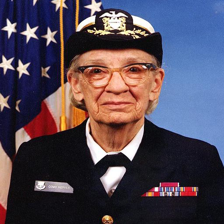

In [0]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper=Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [0]:
grace_hopper=np.array(grace_hopper)/255.0

In [0]:
result=classifier.predict(grace_hopper[np.newaxis,])
predict_class=np.argmax(result[0])
predict_class

653

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

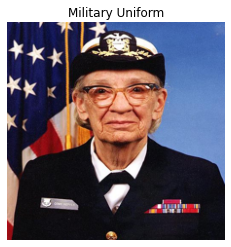

In [0]:
plt.imshow(grace_hopper)
plt.axis("off")
predict_class_name=imagenet_labels[predict_class]
_=plt.title(predict_class_name.title())

In [0]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [0]:
image_generator=keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data=image_generator.flow_from_directory(str(data_root),target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [0]:
for image_batch,label_batch in image_data:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 224, 224, 3)
(32, 5)


In [0]:
raw_classifier_result_batch=classifier.predict(image_batch)
predict_class_names=imagenet_labels[np.argmax(raw_classifier_result_batch,axis=-1)]

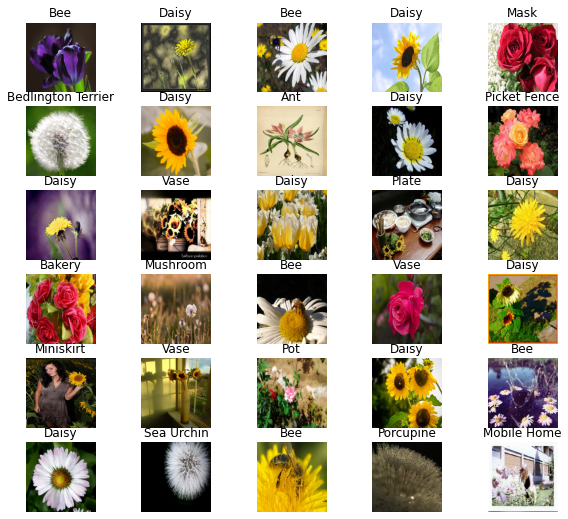

In [0]:
fig=plt.figure(figsize=(10,9))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.imshow(image_batch[i])
  plt.axis("off")
  _=plt.title(predict_class_names[i].title())

In [0]:
feature_extractor_url = "https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor_layer=hub.KerasLayer(feature_extractor_url,input_shape=(224,224,3)) 

In [0]:
feature_batch=feature_extractor_layer(image_batch)
feature_batch.shape

TensorShape([32, 1280])

In [0]:
feature_extractor_layer.trainable=False

In [0]:
model=keras.Sequential([
  feature_extractor_layer,
  keras.layers.Dense(image_data.num_classes)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [0]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()
history=model.fit(
    image_data,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    callbacks=[batch_stats_callback])

Epoch 1/5
115/115 [==============================] - 127s 1s/step - loss: 0.5002 - acc: 0.7500
Epoch 2/5
115/115 [==============================] - 126s 1s/step - loss: 0.2824 - acc: 0.9062
Epoch 3/5
115/115 [==============================] - 127s 1s/step - loss: 0.3214 - acc: 0.9062
Epoch 4/5
115/115 [==============================] - 129s 1s/step - loss: 0.1794 - acc: 0.9062
Epoch 5/5
115/115 [==============================] - 124s 1s/step - loss: 0.0790 - acc: 0.9688


In [0]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

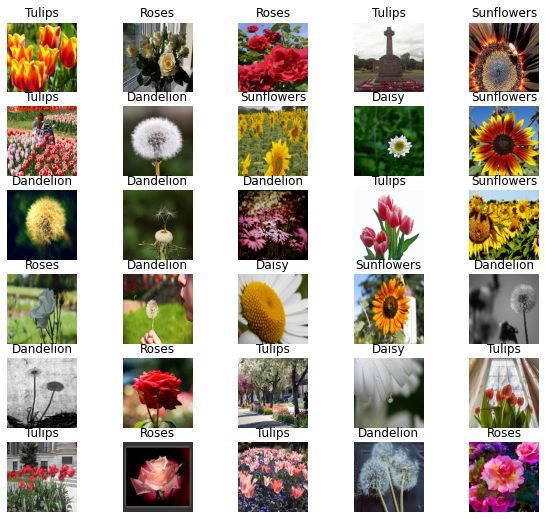

In [0]:
raw_classifier_result_batch=model.predict(image_batch)
predict_class_names=class_names[np.argmax(raw_classifier_result_batch,axis=-1)]
fig=plt.figure(figsize=(10,9))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.imshow(image_batch[i])
  plt.axis("off")
  _=plt.title(predict_class_names[i].title())
  # _=plt.title(label_batch[i].title())

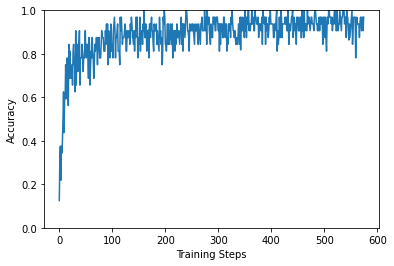

In [0]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)